## Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics

from src.models import CustomFFNN
from src.data_import import get_naive_dataset, load_data, get_train_dataset
from src.plots import plot_loss, plot_heatmap
from src.utils import get_scores
from src.plot_and_predict import predict_and_plot_naive_model, predict_and_plot_pann_model

2024-12-15 16:04:20.540327: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 16:04:20.543456: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 16:04:20.553846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 16:04:20.571937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 16:04:20.576542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 16:04:20.591383: I tensorflow/core/platform/cpu_feature_gu

## Load Datasets

In [2]:
calibration_dir = os.path.abspath('calibration')
test_dir = os.path.abspath('test')

train_names = ['biaxial', 'pure_shear', 'uniaxial']
test_names = ['biax_test', 'mixed_test']
train_paths = {name: os.path.join(calibration_dir, f'{name}.txt') for name in train_names}
test_paths = {name: os.path.join(test_dir, f'{name}.txt') for name in test_names}

train_data = {key: load_data(path) for key, path in train_paths.items()}
test_data = {key: load_data(path) for key, path in test_paths.items()}

# Task 2.2 - Naive Model approach

### Model Initialization and Training

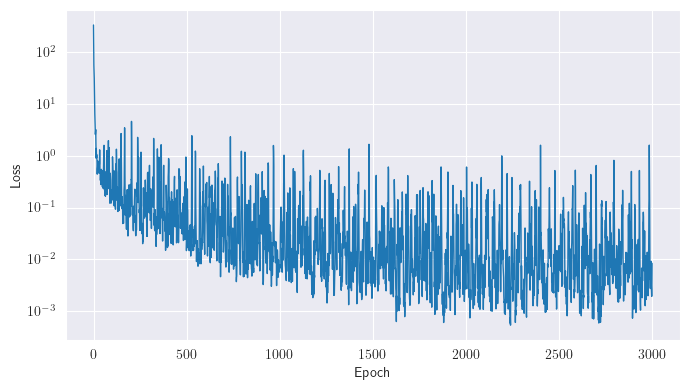

In [3]:
train_features, train_labels = get_train_dataset(train_data, get_naive_dataset, train_names)
naive_model = CustomFFNN(
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model.fit(train_features, train_labels, batch_size=16, epochs=3000, verbose=0)
loss = h.history['loss']
plot_loss(loss)

### Model Evaluation

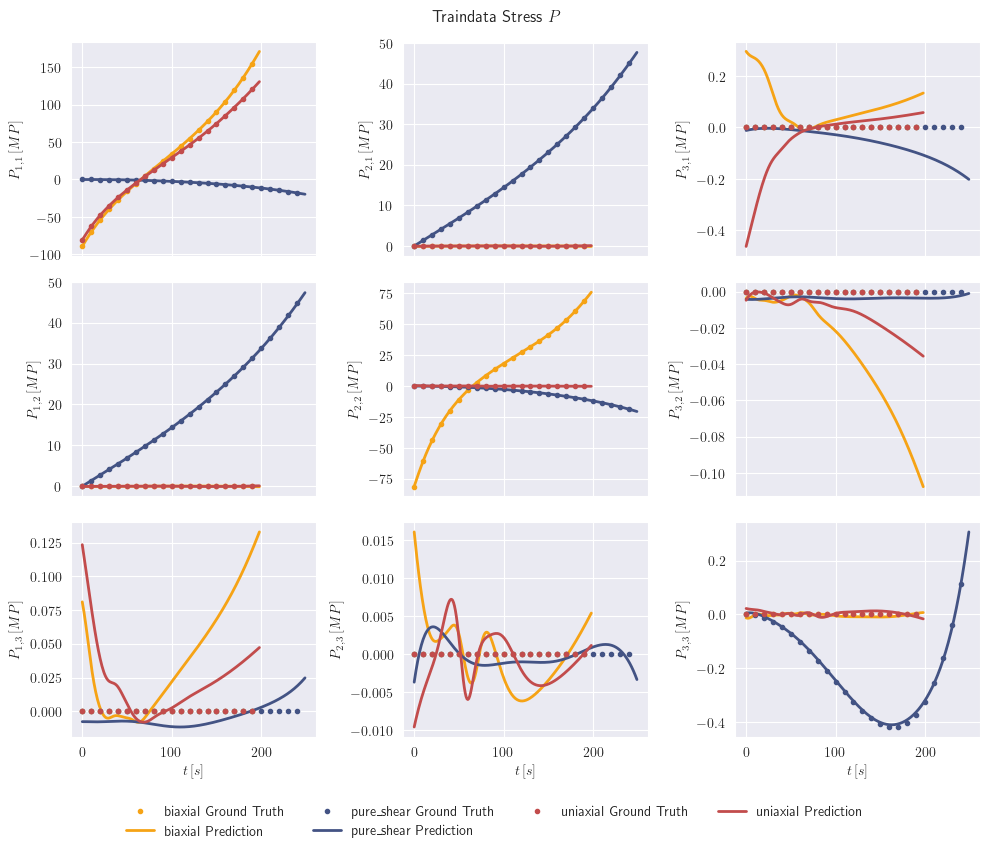

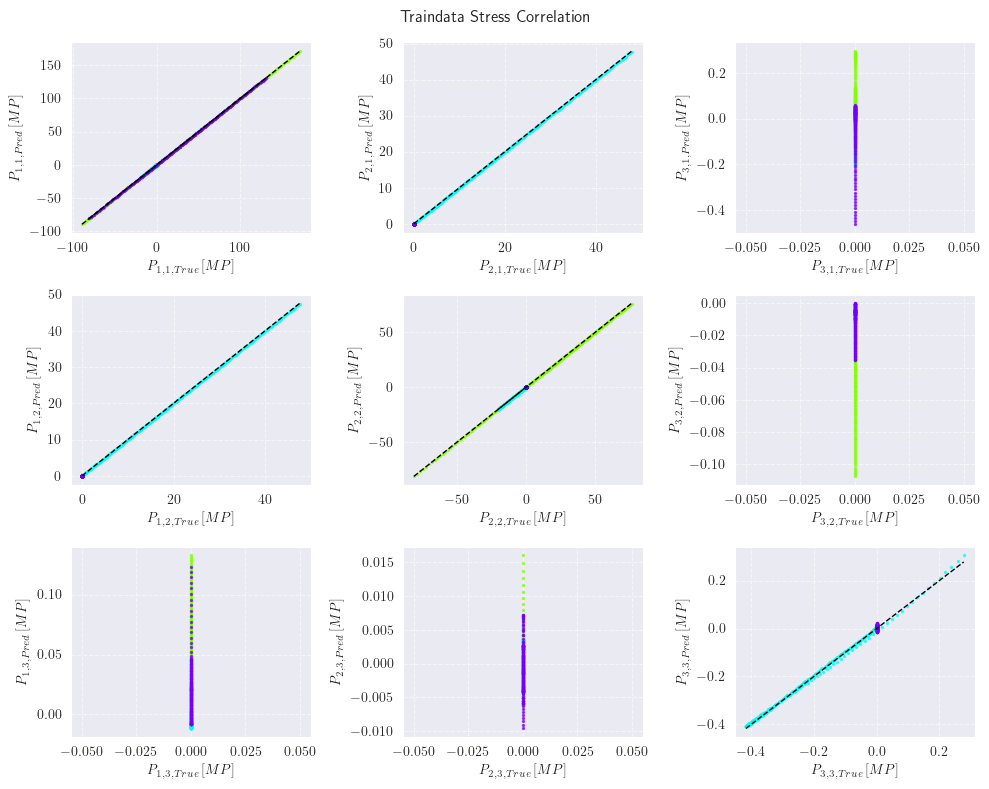

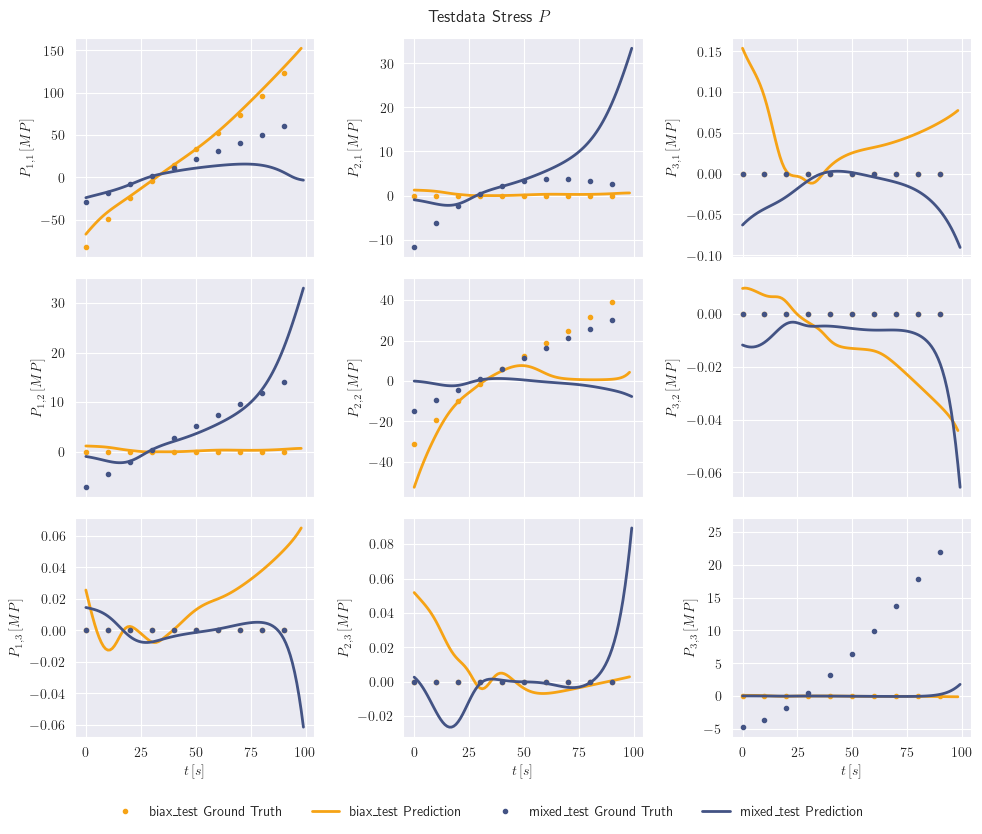

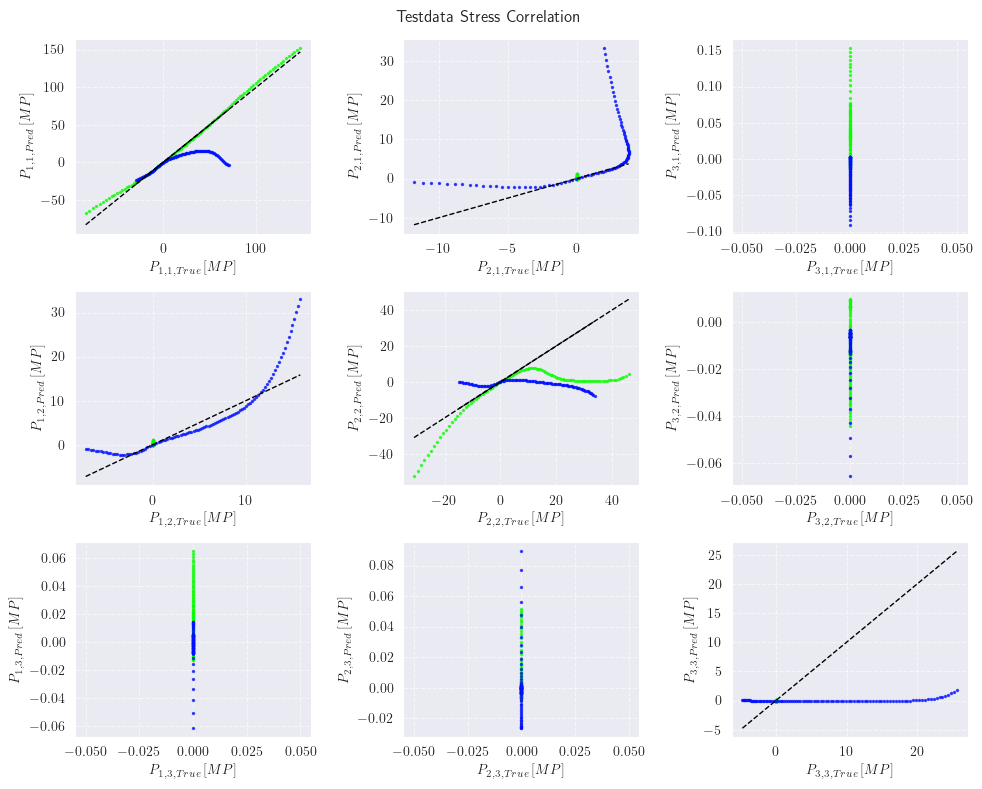

In [4]:
predict_and_plot_naive_model(naive_model, train_data, suptitle='Traindata')
test_labels, test_predictions = predict_and_plot_naive_model(naive_model, test_data, suptitle='Testdata')

### Get scores

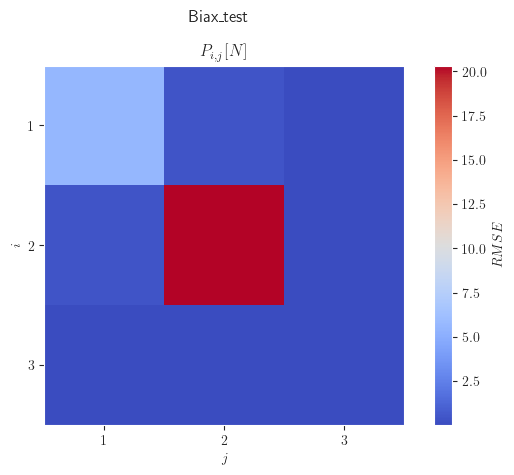

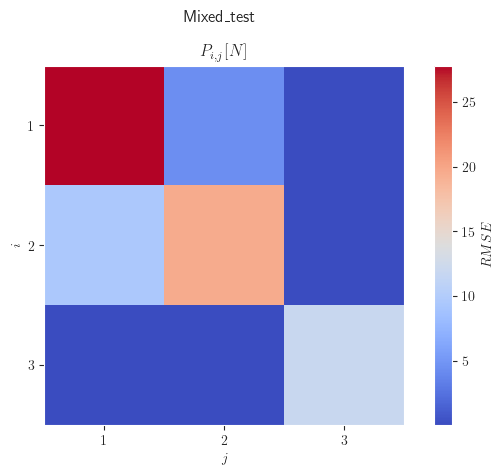

In [6]:
scores = get_scores(test_labels, test_predictions, type='rmse')
for name, values in scores.items():
    plot_heatmap(values, vmin=None, vmax=None, suptitle=name.capitalize(), cbar_label='$RMSE$')

## Loss weighting strategy

In [18]:
def get_weight(tensor: tf.Tensor) -> tf.Tensor:
    batch_size = tensor.shape[0]
    norms = tf.linalg.norm(tensor, axis=1, ord='euclidean')
    weights = tf.reduce_mean(norms)
    return tf.repeat(weights, batch_size)
    
weight_dict = {key: get_weight(tup[1]) for key, tup in train_data.items()}
print('Weights:', *((key, values[0].numpy()) for key, values in weight_dict.items()) )

Weights: ('biaxial', 32.052246) ('pure_shear', 14.206286) ('uniaxial', 17.244076)


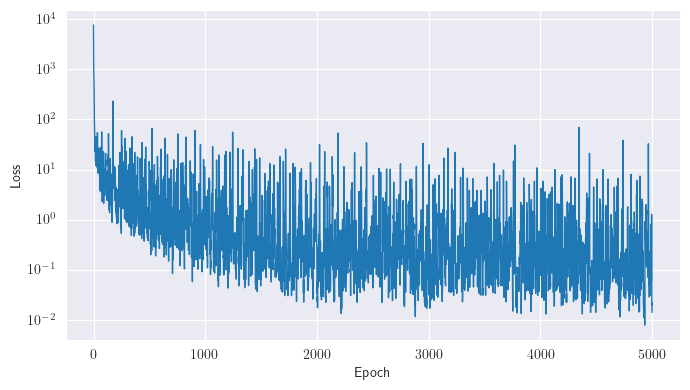

In [9]:
train_features, train_labels = get_train_dataset(train_data, get_naive_dataset, train_names)
sample_weights = tf.concat([weight_dict[key] for key in train_names], axis=0)
naive_model_weighted = CustomFFNN( 
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model_weighted.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model_weighted.fit(train_features, train_labels, batch_size=16, epochs=5000, verbose=0, sample_weight=sample_weights)
loss = h.history['loss']
plot_loss(loss)

### Model Evaluation

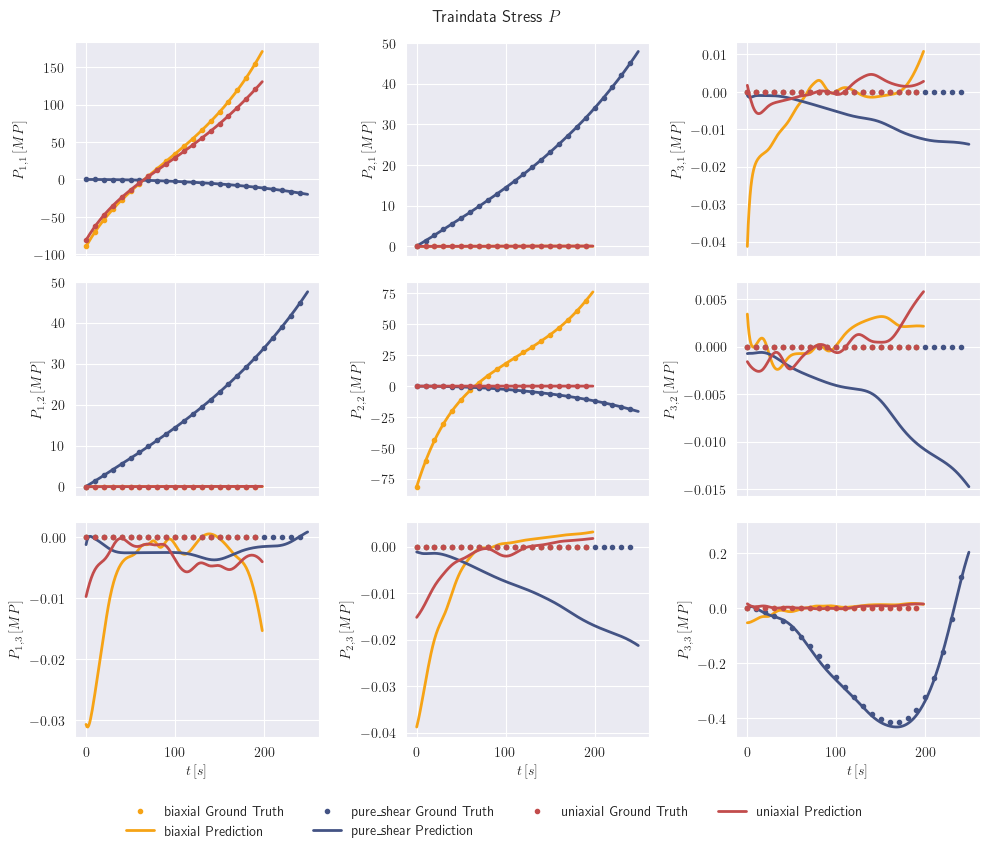

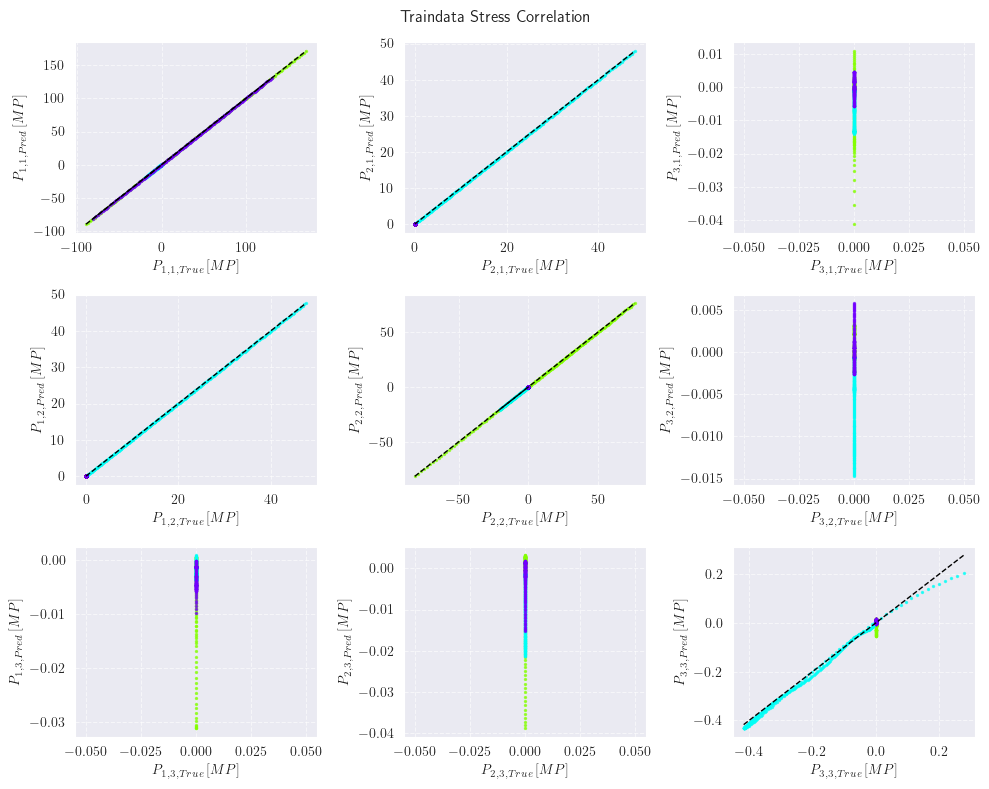

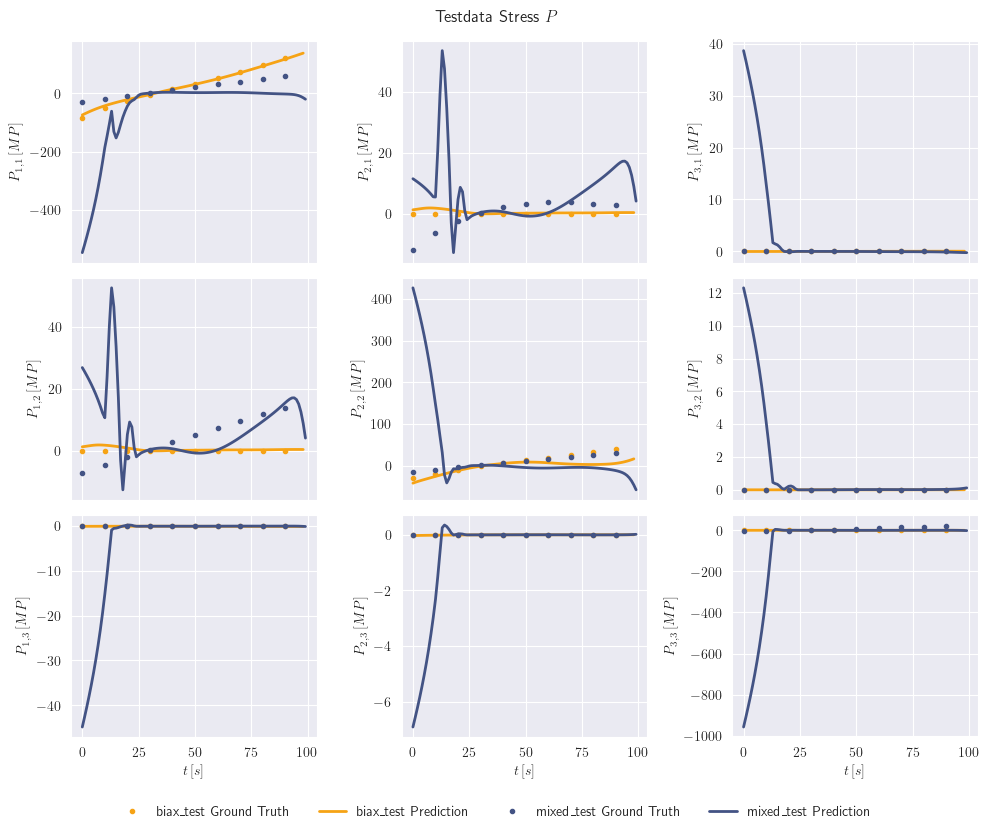

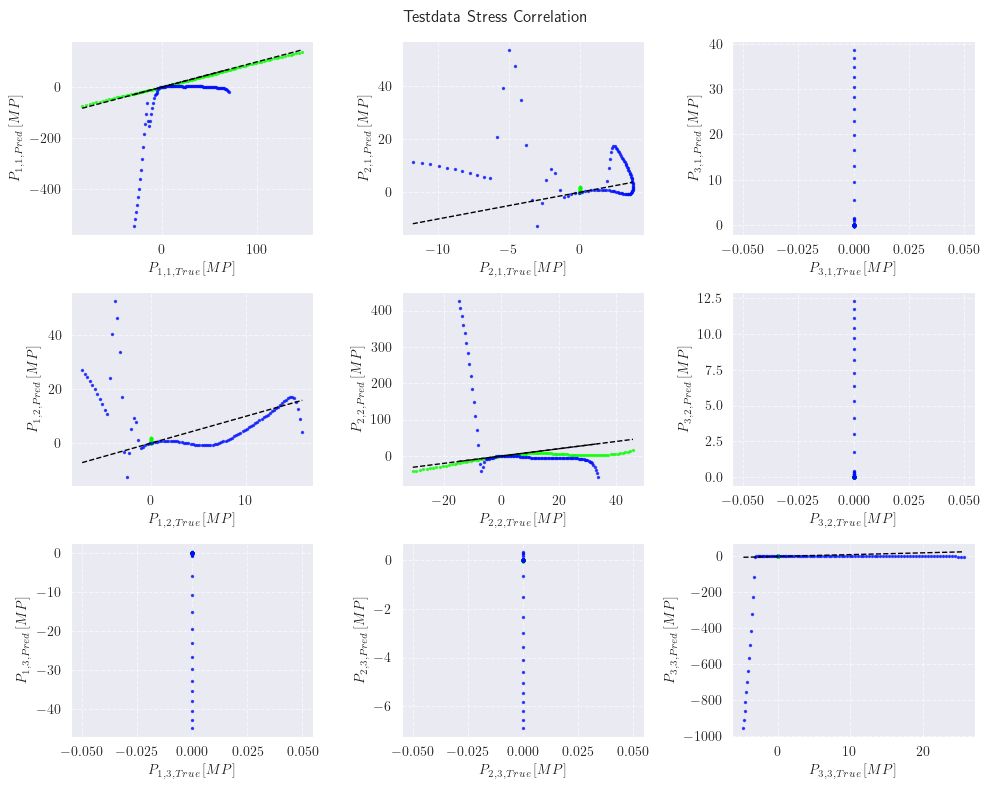

In [10]:
predict_and_plot_naive_model(naive_model_weighted, train_data, suptitle='Traindata')
test_labels, test_predictions = predict_and_plot_naive_model(naive_model_weighted, test_data, suptitle='Testdata')

### Get scores

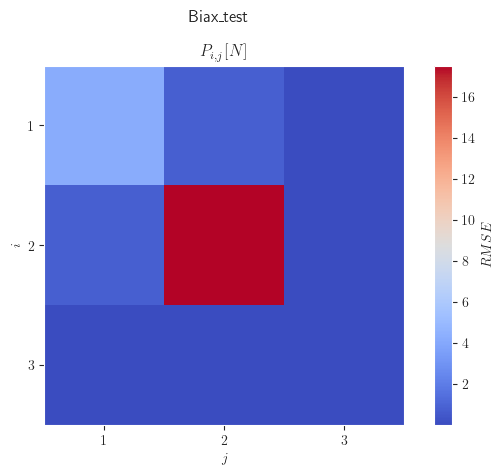

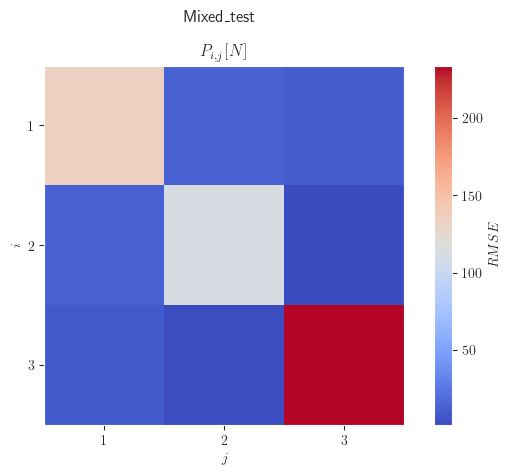

In [11]:
scores = get_scores(test_labels, test_predictions, type='rmse')
for name, values in scores.items():
    plot_heatmap(values, vmin=None, vmax=None, suptitle=name.capitalize(), cbar_label='$RMSE$')
